# Example usage of the Algos
Here the optimal solution is the one within the constraints and with MIN cost

# Import Required libraries

In [ ]:
!pip install pulp #install pulp if not present
import time
import os
import pulp
import itertools
import heapq
from collections import defaultdict
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Define Lambda functions and applications

In [6]:
@dataclass
class Label:
    """A label for the CSP algorithm, representing a path to a function."""
    cost: float
    latency: int
    current_group_mem: int
    partitioning: Tuple[Tuple['LambdaFunction', ...], ...]

    def __lt__(self, other):
        return self.cost < other.cost

@dataclass
class LambdaFunction:
    """Represents a serverless function with its properties, now including load."""
    id: str
    name: str
    memory: int
    baseline_runtime: int
    load_factor: float = 1.0
    data_out_edges: Dict[str, int] = field(default_factory=dict)
    parent: Optional['LambdaFunction'] = None
    children: List['LambdaFunction'] = field(default_factory=list)

    @property
    def runtime(self) -> int:
        """The actual runtime, adjusted for the current load factor."""
        return int(self.baseline_runtime * self.load_factor)

    def add_child(self, child: 'LambdaFunction', data_bytes: int = 0):
        self.children.append(child)
        child.parent = self
        self.data_out_edges[child.id] = data_bytes

    def get_data_transfer_cost(self, child_id: str) -> float:
        bytes_transferred = self.data_out_edges.get(child_id, 0)

        return (bytes_transferred / (1024 * 1024 * 1024)) * 0.01

    def get_execution_cost(self) -> float:
        """Execution cost is now based on the load-adjusted runtime."""
        gb_seconds = (self.memory / 1024) * (self.runtime / 1000)
        return 0.00001667 * gb_seconds

    def __hash__(self):
        return hash(self.id)

    def __eq__(self, other):
        return isinstance(other, LambdaFunction) and self.id == other.id

    def __repr__(self):
        return f"LambdaFunction(id='{self.id}')"


@dataclass
class CompositeFunction:
    """
    Represents a fused group of functions, treated as a single deployable unit.
    The internal sequence of member functions is preserved.
    """
    member_functions: List[LambdaFunction]

    @property
    def id(self) -> str:
        return self.member_functions[0].id

    @property
    def memory(self) -> int:
        """Total memory is the sum of memories of all member functions."""
        return sum(f.memory for f in self.member_functions)

    @property
    def runtime(self) -> int:
        """Total runtime is the sum of runtimes of all members, executed sequentially."""
        return sum(f.runtime for f in self.member_functions)

    def get_execution_cost(self) -> float:
        """
        Calculates the cost for a SINGLE invocation of this composite function,
        billed for its total runtime and total memory.
        """
        gb_seconds = (self.memory / 1024) * (self.runtime / 1000)
        return 0.00001667 * gb_seconds

@dataclass
class Application:
    """Encapsulates a serverless application's structure and constraints."""
    name: str
    functions: List[LambdaFunction]
    critical_path_ids: List[str]
    max_memory: int
    max_latency: int
    network_hop_delay: int = 10

    @property
    def functions_map(self) -> Dict[str, LambdaFunction]:
        return {f.id: f for f in self.functions}

    @property
    def root_function(self) -> LambdaFunction:
        return next(f for f in self.functions if f.parent is None)

    @property
    def critical_path_functions(self) -> List[LambdaFunction]:
        return [self.functions_map[fid] for fid in self.critical_path_ids]

# Create one Class to have all the Fusion algos

In [7]:
class FusionAlgorithms:
    """FusionAlgorithms_3"""

    @staticmethod
    def _get_func_to_group_map(groups: List[CompositeFunction]) -> Dict[str, CompositeFunction]:
        """Maps each atomic function ID to its parent composite group."""
        func_map = {}
        for group in groups:
            for func in group.member_functions:
                func_map[func.id] = group
        return func_map

    @staticmethod
    def calculate_metrics(groups_of_funcs: List[List[LambdaFunction]], app: Application) -> Dict[str, Any]:
        """
        REFactored metrics calculation based on the CompositeFunction model.
        This is the new "judge" that evaluates the output of all algorithms.
        """
        composite_groups = [CompositeFunction(g) for g in groups_of_funcs]
        func_to_composite_map = FusionAlgorithms._get_func_to_group_map(composite_groups)

        total_cost = sum(group.get_execution_cost() for group in composite_groups)

        for func in app.functions:
            parent_group = func_to_composite_map.get(func.id)
            for child in func.children:
                child_group = func_to_composite_map.get(child.id)
                if parent_group and child_group and parent_group.id != child_group.id:
                    total_cost += func.get_data_transfer_cost(child.id)

        latency = 0.0
        critical_path = app.critical_path_functions
        if critical_path:
            latency = sum(f.runtime for f in critical_path)
            for i in range(len(critical_path) - 1):
                parent, child = critical_path[i], critical_path[i+1]
                parent_group = func_to_composite_map.get(parent.id)
                child_group = func_to_composite_map.get(child.id)
                if parent_group and child_group and parent_group.id != child_group.id:
                    latency += app.network_hop_delay

        mem_feasible = all(group.memory <= app.max_memory for group in composite_groups)
        lat_feasible = latency <= app.max_latency
        is_feasible = mem_feasible and lat_feasible

        return {'cost': total_cost, 'latency': latency, 'feasible': is_feasible}

    @staticmethod
    def no_fusion(app: Application) -> Dict:
        start_time = time.time()
        groups = [[func] for func in app.functions]
        metrics = FusionAlgorithms.calculate_metrics(groups, app)
        return {'name': 'NoFusion', 'groups': groups, **metrics, 'runtime': (time.time() - start_time) * 1000}

    @staticmethod
    def singleton(app: Application) -> Dict:
        start_time = time.time()
        q = [app.root_function]
        head = 0
        topo_sorted_funcs = []
        visited = {app.root_function.id}
        while head < len(q):
            node = q[head]; head += 1
            topo_sorted_funcs.append(node)
            for child in node.children:
                if child.id not in visited:
                    visited.add(child.id)
                    q.append(child)

        groups = [topo_sorted_funcs]
        metrics = FusionAlgorithms.calculate_metrics(groups, app)
        return {'name': 'Singleton', 'groups': groups, **metrics, 'runtime': (time.time() - start_time) * 1000}

    @staticmethod
    def min_w_cut_heuristic(app: Application) -> Dict:
        start_time = time.time()
        groups = [[f] for f in app.functions]
        merge_candidates = []
        for f in app.functions:
            for child in f.children:
                merge_candidates.append((f.get_data_transfer_cost(child.id), f, child))
        merge_candidates.sort(key=lambda x: x[0], reverse=True)

        for _, parent, child in merge_candidates:
            temp_group_map = {f.id: i for i, g in enumerate(groups) for f in g}
            parent_idx, child_idx = temp_group_map.get(parent.id), temp_group_map.get(child.id)

            if parent_idx is not None and child_idx is not None and parent_idx != child_idx:
                parent_group, child_group = groups[parent_idx], groups[child_idx]
                if sum(f.memory for f in parent_group) + sum(f.memory for f in child_group) <= app.max_memory:

                    groups[parent_idx].extend(child_group)
                    groups.pop(child_idx)
        metrics = FusionAlgorithms.calculate_metrics(groups, app)
        return {'name': 'MinWCut Heuristic', 'groups': groups, **metrics, 'runtime': (time.time() - start_time) * 1000}

    @staticmethod
    def greedy_tree_partitioning(app: Application) -> Dict:
        start_time = time.time()
        initial_cuts = set()
        critical_path = app.critical_path_functions
        critical_path_edges = list(zip(critical_path[:-1], critical_path[1:]))
        base_latency = sum(f.runtime for f in critical_path)
        if base_latency > app.max_latency:
             return {'name': 'Greedy TP (GrTP)', 'groups': [], 'cost': float('inf'), 'latency': base_latency, 'feasible': False, 'runtime': (time.time() - start_time) * 1000}

        for k in range(len(critical_path_edges) + 1):
            is_k_feasible = False
            for merge_combination in itertools.combinations(critical_path_edges, k):
                num_external_invocations = len(critical_path_edges) - len(merge_combination)
                current_latency = base_latency + num_external_invocations * app.network_hop_delay
                if current_latency <= app.max_latency:
                    initial_cuts = set(critical_path_edges) - set(merge_combination)
                    is_k_feasible = True
                    break
            if is_k_feasible:
                break

        initial_barrier_nodes = {app.root_function} | {child for _, child in initial_cuts}
        groups_dict = {b.id: [b] for b in initial_barrier_nodes}
        node_to_barrier_map = {b.id: b for b in initial_barrier_nodes}
        q = list(initial_barrier_nodes)
        head = 0
        while head < len(q):
            current_node = q[head]; head += 1
            barrier_node = node_to_barrier_map[current_node.id]
            for child in current_node.children:
                if child.id not in node_to_barrier_map:
                    node_to_barrier_map[child.id] = barrier_node
                    groups_dict[barrier_node.id].append(child)
                    q.append(child)

        groups = list(groups_dict.values())
        merge_candidates = []
        for f in app.functions:
            for child in f.children:
                if (f, child) not in initial_cuts:
                    merge_candidates.append((f.get_data_transfer_cost(child.id), f, child))
        merge_candidates.sort(key=lambda x: x[0], reverse=True)

        for _, parent, child in merge_candidates:
            temp_group_map = {f.id: i for i, g in enumerate(groups) for f in g}
            parent_idx, child_idx = temp_group_map.get(parent.id), temp_group_map.get(child.id)
            if parent_idx is not None and child_idx is not None and parent_idx != child_idx:
                parent_group, child_group = groups[parent_idx], groups[child_idx]
                if sum(f.memory for f in parent_group) + sum(f.memory for f in child_group) <= app.max_memory:
                    groups[parent_idx].extend(child_group)
                    groups.pop(child_idx)

        metrics = FusionAlgorithms.calculate_metrics(groups, app)
        return {'name': 'Greedy TP (GrTP)', 'groups': groups, **metrics, 'runtime': (time.time() - start_time) * 1000}

    @staticmethod
    def costless_csp(app: Application) -> Dict:
        start_time = time.time()
        chain = app.critical_path_functions
        if not chain: return {'name': 'Costless (CSP)', 'groups': [], 'feasible': False, 'error': 'No critical path.'}

        @dataclass
        class CSPLabel:
            cost: float; latency: int; current_group_mem: int; partitioning: Tuple[Tuple[LambdaFunction, ...], ...]
            def __lt__(self, other): return self.cost < other.cost

        labels = defaultdict(list)
        pq = []
        start_node = chain[0]
        initial_label = CSPLabel(cost=0, latency=start_node.runtime, current_group_mem=start_node.memory, partitioning=((start_node,),))
        labels[start_node.id].append(initial_label)
        heapq.heappush(pq, (initial_label.cost, start_node.id, initial_label))

        while pq:
            _, u_id, u_label = heapq.heappop(pq)
            u = app.functions_map[u_id]
            u_index = chain.index(u)
            if u_index + 1 >= len(chain): continue
            v = chain[u_index + 1]

            if u_label.current_group_mem + v.memory <= app.max_memory:
                new_part_merge = list(u_label.partitioning); new_part_merge[-1] += (v,)
                new_label_merge = CSPLabel(cost=u_label.cost, latency=u_label.latency + v.runtime, current_group_mem=u_label.current_group_mem + v.memory, partitioning=tuple(new_part_merge))
                if not any(l.cost <= new_label_merge.cost and l.latency <= new_label_merge.latency for l in labels[v.id]):
                    labels[v.id] = [l for l in labels[v.id] if not (new_label_merge.cost <= l.cost and new_label_merge.latency <= l.latency)]
                    labels[v.id].append(new_label_merge)
                    heapq.heappush(pq, (new_label_merge.cost, v.id, new_label_merge))

            new_label_cut = CSPLabel(cost=u_label.cost + u.get_data_transfer_cost(v.id), latency=u_label.latency + v.runtime + app.network_hop_delay, current_group_mem=v.memory, partitioning=u_label.partitioning + ((v,),))
            if not any(l.cost <= new_label_cut.cost and l.latency <= new_label_cut.latency for l in labels[v.id]):
                labels[v.id] = [l for l in labels[v.id] if not (new_label_cut.cost <= l.cost and new_label_cut.latency <= l.latency)]
                labels[v.id].append(new_label_cut)
                heapq.heappush(pq, (new_label_cut.cost, v.id, new_label_cut))

        best_label = min([l for l in labels[chain[-1].id] if l.latency <= app.max_latency], key=lambda l: l.cost, default=None)
        if not best_label: return {'name': 'Costless (CSP)', 'groups': [], 'feasible': False, 'runtime': (time.time() - start_time) * 1000, 'error': 'Infeasible on critical path'}

        final_groups = [list(g) for g in best_label.partitioning]
        assigned_funcs = {f for g in final_groups for f in g}
        for func in app.functions:
            if func not in assigned_funcs: final_groups.append([func])

        metrics = FusionAlgorithms.calculate_metrics(final_groups, app)
        return {'name': 'Costless (CSP)', 'groups': final_groups, **metrics, 'runtime': (time.time() - start_time) * 1000}

    @staticmethod
    def mtx_ilp(app: Application) -> Dict:
        start_time = time.time()
        if not pulp: return {'name': 'MtxILP (Optimal)', 'feasible': False, 'runtime': 0, 'error': 'pulp not installed'}

        prob = pulp.LpProblem("Fusion_MtxILP", pulp.LpMinimize)
        roots = app.functions
        x = pulp.LpVariable.dicts("x", ((b.id, f.id) for b in roots for f in app.functions), cat='Binary')
        all_edges = [(u, v) for u in app.functions for v in u.children]
        is_cut = pulp.LpVariable.dicts("is_cut", ((e[0].id, e[1].id) for e in all_edges), cat='Binary')

        prob += pulp.lpSum(u.get_data_transfer_cost(v.id) * is_cut[u.id, v.id] for u, v in all_edges), "Minimize_Transfer_Cost"

        for f in app.functions: prob += pulp.lpSum(x[b.id, f.id] for b in roots) == 1, f"Assign_{f.id}"
        for b in roots:
            for f in app.functions:
                prob += x[b.id, f.id] <= x[b.id, b.id], f"Root_Integrity_{b.id}_{f.id}"
                # if f.parent: prob += x[b.id, f.id] <= x[b.id, f.parent.id], f"Connectivity_{b.id}_{f.id}"
            prob += pulp.lpSum(f.memory * x[b.id, f.id] for f in app.functions) <= app.max_memory * x[b.id, b.id], f"Memory_{b.id}"
        for u, v in all_edges:
            for b in roots:
                prob += is_cut[u.id, v.id] >= x[b.id, u.id] - x[b.id, v.id], f"Cut_A_{b.id}_{u.id}_{v.id}"
                prob += is_cut[u.id, v.id] >= x[b.id, v.id] - x[b.id, u.id], f"Cut_B_{b.id}_{u.id}_{v.id}"

        critical_path_edges = list(zip(app.critical_path_functions[:-1], app.critical_path_functions[1:]))
        runtime_sum = sum(f.runtime for f in app.critical_path_functions)
        network_overhead = pulp.lpSum(app.network_hop_delay * is_cut[u.id, v.id] for u, v in critical_path_edges)
        prob += runtime_sum + network_overhead <= app.max_latency, "Latency_Constraint"

        prob.solve(pulp.PULP_CBC_CMD(msg=0, timeLimit=60))
        runtime = (time.time() - start_time) * 1000

        if pulp.LpStatus[prob.status] == 'Optimal':
            groups_dict = defaultdict(list)
            for b in roots:
                if pulp.value(x[b.id, b.id]) > 0.5:
                    for f in app.functions:
                        if pulp.value(x[b.id, f.id]) > 0.5: groups_dict[b.id].append(app.functions_map[f.id])
            groups = list(groups_dict.values())
            metrics = FusionAlgorithms.calculate_metrics(groups, app)
            return {'name': 'MtxILP (Optimal)', 'groups': groups, **metrics, 'runtime': runtime}
        else:
            return {'name': 'MtxILP (Optimal)', 'groups': [], 'cost': float('inf'), 'latency': float('inf'), 'feasible': False, 'runtime': runtime, 'error': pulp.LpStatus[prob.status]}

# Case-1: No network Hop or load


  TESTING APPLICATION: IMAGE PROCESSING
  CONSTRAINTS: Max Memory/Group = 1024MB, Max Latency = 700ms

Algorithm            Cost ($)     Latency (ms)    Groups   Runtime (ms)    Feasible   Notes
----------------------------------------------------------------------------------------------------
MtxILP (Optimal)     0.000092     640.0           3        105.06          ✓          (Optimal)
MinWCut Heuristic    0.000095     640.0           3        0.08            ✓          
Costless (CSP)       0.000121     640.0           4        1.34            ✓          
NoFusion             0.000183     660.0           6        0.09            ✓          
Singleton            0.000038     630.0           1        0.05            ✗          
Greedy TP (GrTP)     0.000112     660.0           4        0.12            ✗          

Visualizing best feasible solution from 'MtxILP (Optimal)'...


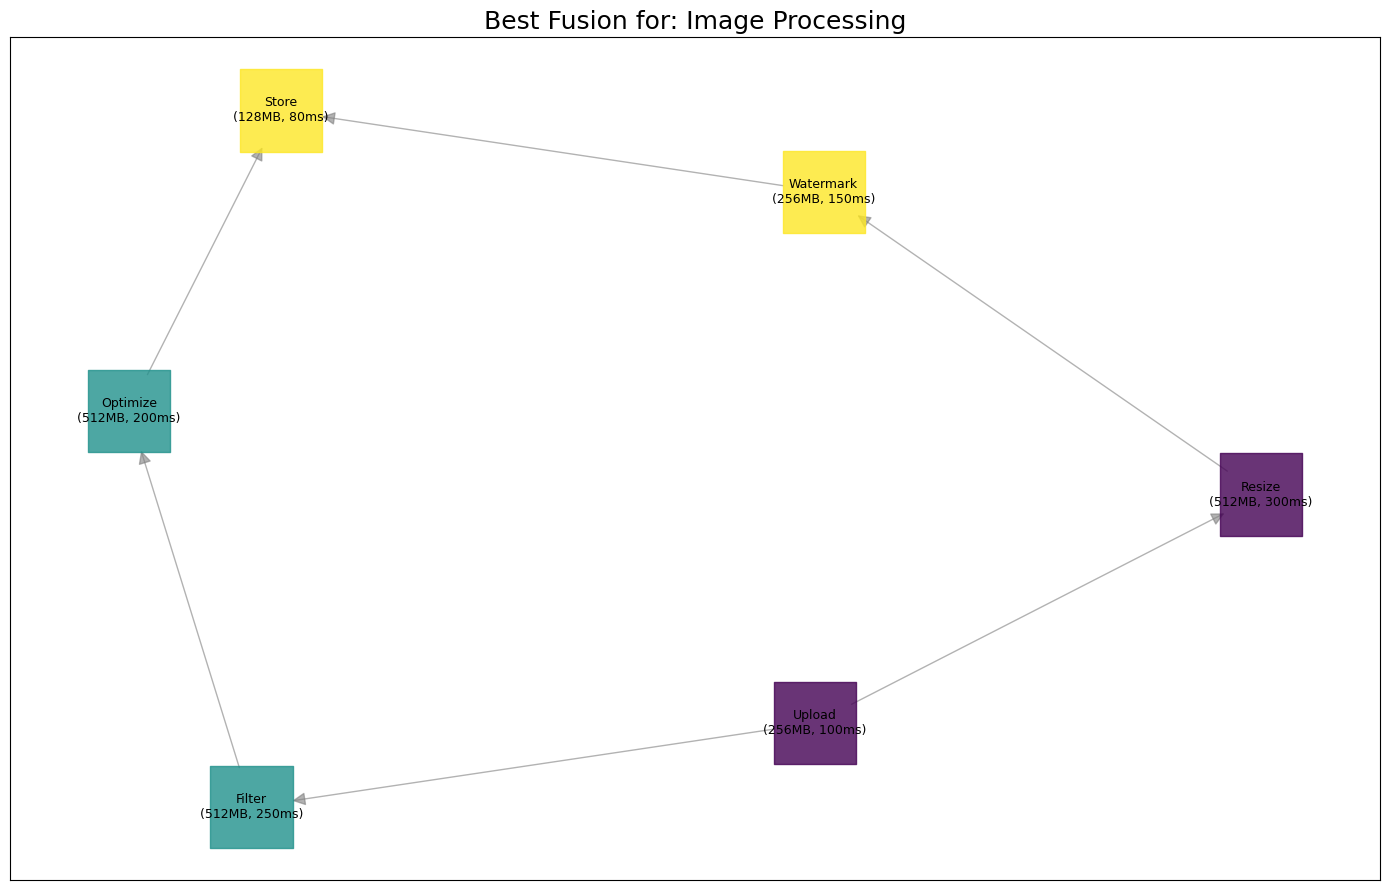

Saved fusion graph to: fusion_results/best_fusion_Image_Processing.png

  TESTING APPLICATION: DATA ANALYSIS
  CONSTRAINTS: Max Memory/Group = 2048MB, Max Latency = 1500ms

Algorithm            Cost ($)     Latency (ms)    Groups   Runtime (ms)    Feasible   Notes
----------------------------------------------------------------------------------------------------
MtxILP (Optimal)     0.000113     1210.0          2        94.95           ✓          (Optimal)
MinWCut Heuristic    0.000137     1210.0          2        0.07            ✓          
Costless (CSP)       0.000153     1210.0          3        1.26            ✓          
Greedy TP (GrTP)     0.000246     1240.0          4        0.10            ✓          
NoFusion             0.000317     1240.0          6        0.11            ✓          
Singleton            0.000070     1200.0          1        0.05            ✗          

Visualizing best feasible solution from 'MtxILP (Optimal)'...


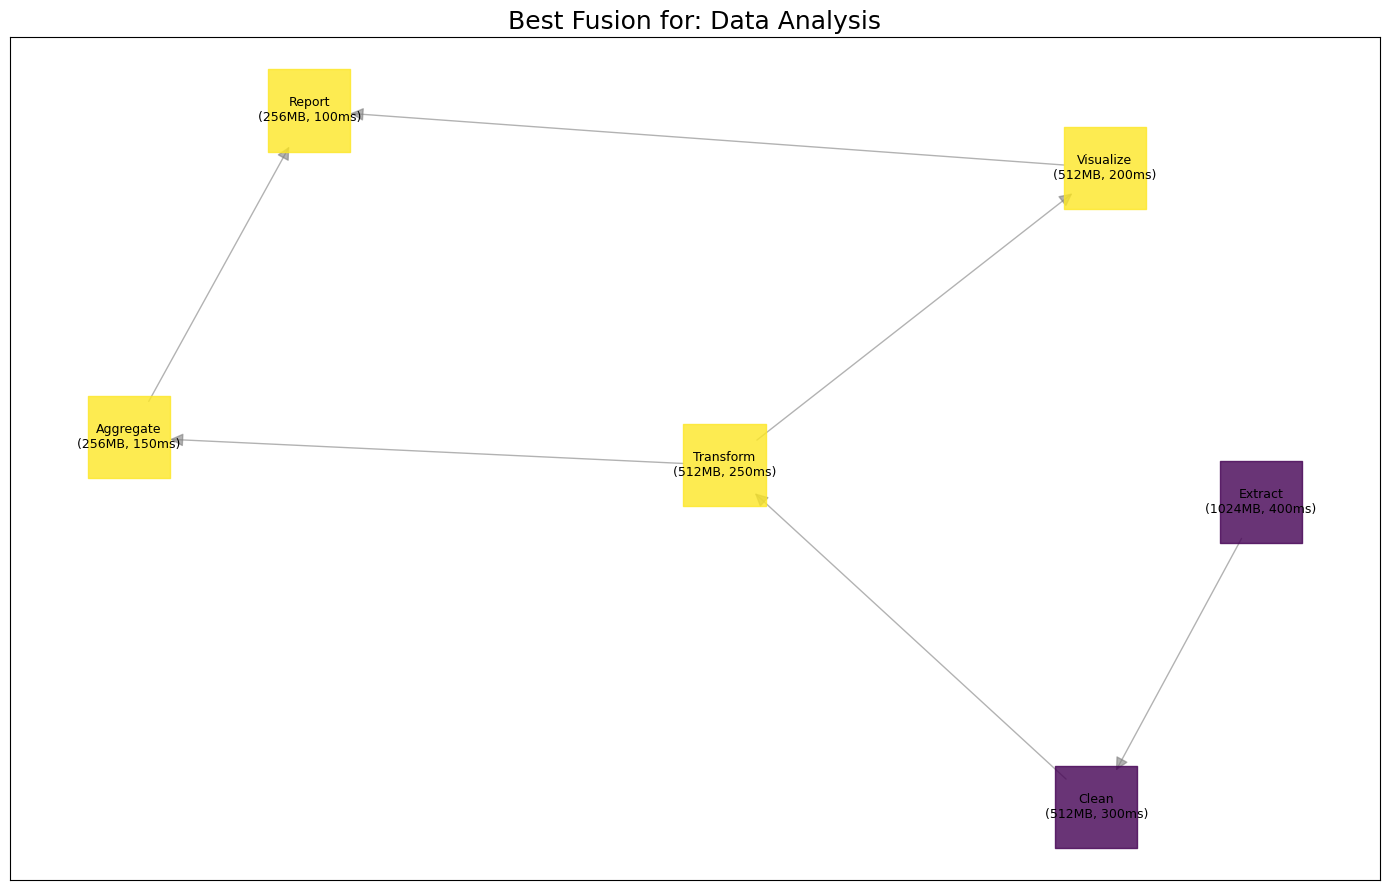

Saved fusion graph to: fusion_results/best_fusion_Data_Analysis.png


In [14]:
class ApplicationBuilder:
    @staticmethod
    def create_from_spec(spec: Dict) -> Application:
        functions = {fid: LambdaFunction(id=fid, name=props['name'], memory=props['mem'], baseline_runtime=props['rt']) for fid, props in spec['functions'].items()}
        for fid, props in spec['functions'].items():
            if 'children' in props:
                for child_id, data_bytes in props['children'].items():
                    functions[fid].add_child(functions[child_id], data_bytes)
        return Application(name=spec['name'], functions=list(functions.values()), critical_path_ids=spec['critical_path'], max_memory=spec['constraints']['max_memory'], max_latency=spec['constraints']['max_latency'])

class FusionTester:
    def __init__(self, output_dir="fusion_results"):
        self.output_dir = output_dir
        if not os.path.exists(self.output_dir): os.makedirs(self.output_dir)

    def run_test_on_app(self, app: Application):
        print(f"\n{'=' * 90}")
        print(f"  TESTING APPLICATION: {app.name.upper()}")
        print(f"  CONSTRAINTS: Max Memory/Group = {app.max_memory}MB, Max Latency = {app.max_latency}ms")
        print(f"{'=' * 90}")

        algorithms = [FusionAlgorithms.no_fusion, FusionAlgorithms.singleton, FusionAlgorithms.min_w_cut_heuristic, FusionAlgorithms.greedy_tree_partitioning, FusionAlgorithms.costless_csp, FusionAlgorithms.mtx_ilp]
        results = []
        for alg_func in algorithms:
            try: results.append(alg_func(app))
            except Exception as e: print(f"Error running {alg_func.__name__}: {e}")

        print(f"\n{'Algorithm':<20} {'Cost ($)':<12} {'Latency (ms)':<15} {'Groups':<8} {'Runtime (ms)':<15} {'Feasible':<10} {'Notes'}")
        print("-" * 100)
        feasible_results = [r for r in results if r.get('feasible')]
        optimal_cost = min((r.get('cost', float('inf')) for r in feasible_results), default=float('inf'))
        results.sort(key=lambda x: (not x.get('feasible', False), x.get('cost', float('inf'))))

        for res in results:
            feasible_mark = "✓" if res.get('feasible') else "✗"
            optimal_mark = "(Optimal)" if res.get('feasible') and abs(res.get('cost', float('inf')) - optimal_cost) < 1e-9 else ""
            runtime_str = f"{res.get('runtime', 0):.2f}" if 'runtime' in res and res.get('runtime', 0) > 0 else "N/A"
            note = res.get('error', optimal_mark)
            print(f"{res.get('name', 'Unknown'):<20} {res.get('cost', float('inf')):<12.6f} {res.get('latency', float('inf')):<15.1f} {len(res.get('groups', [])):<8} {runtime_str:<15} {feasible_mark:<10} {note}")

        if feasible_results:
            best_result = min(feasible_results, key=lambda x: x.get('cost', float('inf')))
            print(f"\nVisualizing best feasible solution from '{best_result.get('name', 'Unknown')}'...")
            filename = f"best_fusion_{app.name.replace(' ', '_')}.png"
            self.visualize_fusion(best_result.get('groups', []), f"Best Fusion for: {app.name}", filename)
        else:
            print("\nNo feasible solution found by any algorithm under the given constraints.")
        return results

    def visualize_fusion(self, groups_of_funcs: List[List[LambdaFunction]], title: str, filename: str):
        if not groups_of_funcs: return
        G = nx.DiGraph()
        all_funcs = [func for group in groups_of_funcs for func in group]

        composite_groups = [CompositeFunction(g) for g in groups_of_funcs]
        func_to_composite_map = FusionAlgorithms._get_func_to_group_map(composite_groups)

        colors = plt.cm.viridis(np.linspace(0, 1, len(composite_groups)))

        for func in all_funcs:
            label = f"{func.name.split()[0]}\n({func.memory}MB, {func.runtime}ms)"
            group_obj = func_to_composite_map.get(func.id)
            group_idx = composite_groups.index(group_obj) if group_obj else -1
            G.add_node(func.id, label=label, group_id=group_idx)
        for func in all_funcs:
            for child in func.children:
                if child.id in G: G.add_edge(func.id, child.id)

        plt.figure(figsize=(14, 9))
        pos = nx.spring_layout(G, seed=42, k=1.5, iterations=70)

        valid_nodes = [node for node in G.nodes() if 0 <= G.nodes[node]['group_id'] < len(colors)]
        valid_colors = [colors[G.nodes[node]['group_id']] for node in valid_nodes]

        nx.draw_networkx_nodes(G, pos, nodelist=valid_nodes, node_size=3500, node_color=valid_colors, node_shape='s', alpha=0.8)
        nx.draw_networkx_edges(G, pos, alpha=0.6, edge_color='gray', arrows=True, arrowsize=20, node_size=3500)
        labels = {node: G.nodes[node]['label'] for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, font_size=9, font_color='black')
        plt.title(title, fontsize=18); plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, filename));
        plt.show()
        print(f"Saved fusion graph to: {os.path.join(self.output_dir, filename)}")

def get_test_apps():
    image_processing_spec = {'name': 'Image Processing', 'functions': {'upload': {'name': 'Upload', 'mem': 256, 'rt': 100, 'children': {'resize': 5242880, 'filter': 5242880}}, 'resize': {'name': 'Resize', 'mem': 512, 'rt': 300, 'children': {'watermark': 2097152}}, 'filter': {'name': 'Filter', 'mem': 512, 'rt': 250, 'children': {'optimize': 3145728}}, 'watermark': {'name': 'Watermark', 'mem': 256, 'rt': 150, 'children': {'store': 2097152}}, 'optimize': {'name': 'Optimize', 'mem': 512, 'rt': 200, 'children': {'store': 1048576}}, 'store': {'name': 'Store', 'mem': 128, 'rt': 80}}, 'critical_path': ['upload', 'resize', 'watermark', 'store'], 'constraints': {'max_memory': 1024, 'max_latency': 700}}
    data_analysis_spec = {'name': 'Data Analysis', 'functions': {'extract': {'name': 'Extract', 'mem': 1024, 'rt': 400, 'children': {'clean': 10485760}}, 'clean': {'name': 'Clean', 'mem': 512, 'rt': 300, 'children': {'transform': 8388608}}, 'transform': {'name': 'Transform', 'mem': 512, 'rt': 250, 'children': {'aggregate': 4194304, 'visualize': 6291456}}, 'aggregate': {'name': 'Aggregate', 'mem': 256, 'rt': 150, 'children': {'report': 1048576}}, 'visualize': {'name': 'Visualize', 'mem': 512, 'rt': 200, 'children': {'report': 2097152}}, 'report': {'name': 'Report', 'mem': 256, 'rt': 100}}, 'critical_path': ['extract', 'clean', 'transform', 'aggregate', 'report'], 'constraints': {'max_memory': 2048, 'max_latency': 1500}}
    return [ApplicationBuilder.create_from_spec(image_processing_spec), ApplicationBuilder.create_from_spec(data_analysis_spec)]

if __name__ == "__main__":
    # print("This script requires: pulp, matplotlib, networkx, numpy")
    tester = FusionTester()
    for app in get_test_apps():
        tester.run_test_on_app(app)

# Case-2: With varying Load


  TESTING APPLICATION: IMAGE PROCESSING (BASELINE LOAD)
  CONSTRAINTS: Max Memory/Group = 1024MB, Max Latency = 700ms, Network Hop = 10ms
  LOAD PROFILE: upload=1.0x, resize=1.0x, filter=1.0x, watermark=1.0x, optimize=1.0x, store=1.0x

Algorithm            Cost ($)     Latency (ms)    Groups   Runtime (ms)    Feasible   Notes
----------------------------------------------------------------------------------------------------
MtxILP (Optimal)     0.000092     640.0           3        80.01           ✓          (Optimal)
MinWCut Heuristic    0.000095     640.0           3        0.05            ✓          
Costless (CSP)       0.000121     640.0           4        0.78            ✓          
NoFusion             0.000183     660.0           6        0.07            ✓          
Singleton            0.000038     630.0           1        0.03            ✗          
Greedy TP (GrTP)     0.000112     660.0           4        0.06            ✗          

Visualizing best feasible solution fro

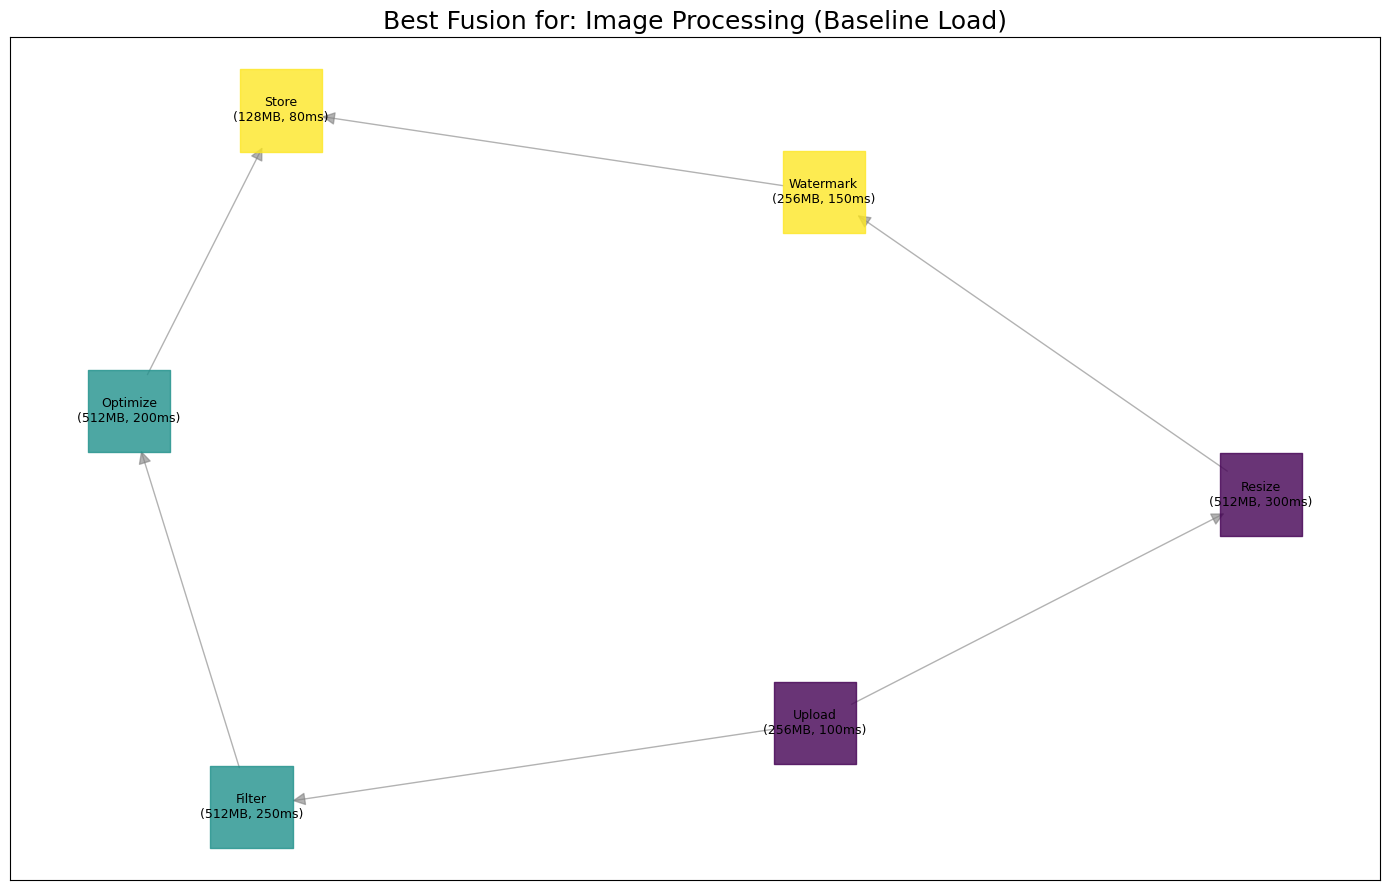

Saved fusion graph to: fusion_results/best_fusion_Image_Processing_(Baseline_Load).png

  TESTING APPLICATION: IMAGE PROCESSING (HIGH LOAD)
  CONSTRAINTS: Max Memory/Group = 1024MB, Max Latency = 700ms, Network Hop = 10ms
  LOAD PROFILE: upload=1.0x, resize=1.2x, filter=1.5x, watermark=1.0x, optimize=1.5x, store=1.0x

Algorithm            Cost ($)     Latency (ms)    Groups   Runtime (ms)    Feasible   Notes
----------------------------------------------------------------------------------------------------
MinWCut Heuristic    0.000100     700.0           3        0.05            ✓          (Optimal)
MtxILP (Optimal)     0.000100     700.0           3        60.94           ✓          (Optimal)
Costless (CSP)       0.000123     700.0           4        0.81            ✓          
Singleton            0.000048     690.0           1        0.04            ✗          
Greedy TP (GrTP)     0.000072     700.0           2        0.06            ✗          
NoFusion             0.000186     

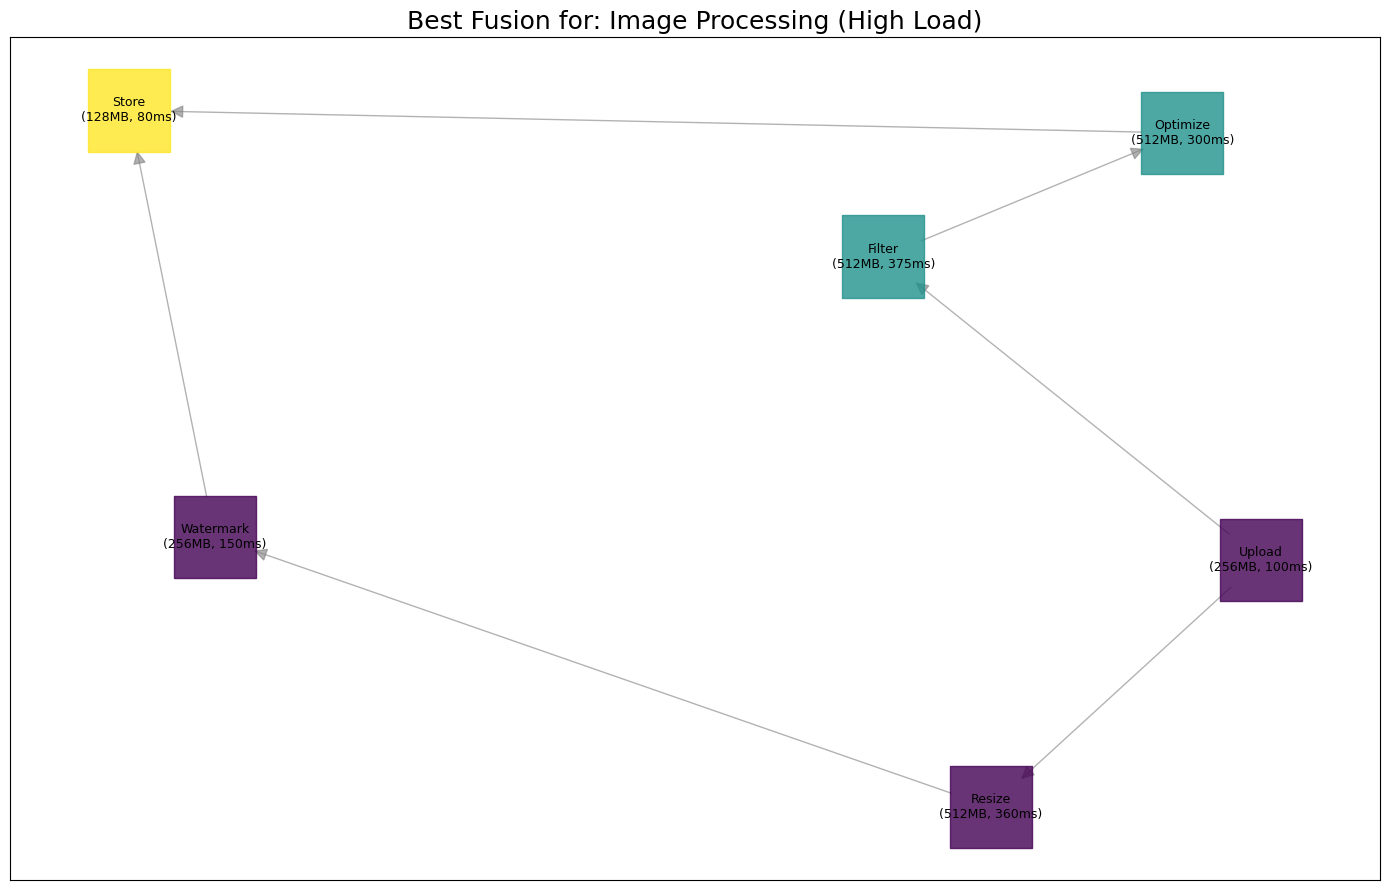

Saved fusion graph to: fusion_results/best_fusion_Image_Processing_(High_Load).png


In [13]:
class ApplicationBuilder:
    @staticmethod
    def create_from_spec(spec: Dict) -> Application:
        functions = {
            fid: LambdaFunction(
                id=fid,
                name=props['name'],
                memory=props['mem'],
                baseline_runtime=props['rt'],
                load_factor=spec.get('loads', {}).get(fid, 1.0)
            ) for fid, props in spec['functions'].items()
        }
        for fid, props in spec['functions'].items():
            if 'children' in props:
                for child_id, data_bytes in props['children'].items():
                    functions[fid].add_child(functions[child_id], data_bytes)
        return Application(
            name=spec['name'],
            functions=list(functions.values()),
            critical_path_ids=spec['critical_path'],
            max_memory=spec['constraints']['max_memory'],
            max_latency=spec['constraints']['max_latency'],
            network_hop_delay=spec['constraints'].get('network_delay', 10)
        )

class FusionTester:
    def __init__(self, output_dir="fusion_results"):
        self.output_dir = output_dir
        if not os.path.exists(self.output_dir): os.makedirs(self.output_dir)

    def run_test_on_app(self, app: Application):
        print(f"\n{'=' * 90}")
        print(f"  TESTING APPLICATION: {app.name.upper()}")
        print(f"  CONSTRAINTS: Max Memory/Group = {app.max_memory}MB, Max Latency = {app.max_latency}ms, Network Hop = {app.network_hop_delay}ms")
        print(f"  LOAD PROFILE: " + ", ".join([f"{f.id}={f.load_factor:.1f}x" for f in app.functions]) or "Baseline (1.0x)")
        print(f"{'=' * 90}")

        algorithms = [FusionAlgorithms.no_fusion, FusionAlgorithms.singleton, FusionAlgorithms.min_w_cut_heuristic, FusionAlgorithms.greedy_tree_partitioning, FusionAlgorithms.costless_csp, FusionAlgorithms.mtx_ilp]
        results = []
        for alg_func in algorithms:
            try: results.append(alg_func(app))
            except Exception as e: print(f"Error running {alg_func.__name__}: {e}")

        print(f"\n{'Algorithm':<20} {'Cost ($)':<12} {'Latency (ms)':<15} {'Groups':<8} {'Runtime (ms)':<15} {'Feasible':<10} {'Notes'}")
        print("-" * 100)
        feasible_results = [r for r in results if r.get('feasible')]
        optimal_cost = min((r.get('cost', float('inf')) for r in feasible_results), default=float('inf'))
        results.sort(key=lambda x: (not x.get('feasible', False), x.get('cost', float('inf'))))

        for res in results:
            feasible_mark = "✓" if res.get('feasible') else "✗"
            optimal_mark = "(Optimal)" if res.get('feasible') and abs(res.get('cost', float('inf')) - optimal_cost) < 1e-9 else ""
            runtime_str = f"{res.get('runtime', 0):.2f}" if 'runtime' in res and res.get('runtime', 0) > 0 else "N/A"
            note = res.get('error', optimal_mark)
            print(f"{res.get('name', 'Unknown'):<20} {res.get('cost', float('inf')):<12.6f} {res.get('latency', float('inf')):<15.1f} {len(res.get('groups', [])):<8} {runtime_str:<15} {feasible_mark:<10} {note}")

        if feasible_results:
            best_result = min(feasible_results, key=lambda x: x.get('cost', float('inf')))
            print(f"\nVisualizing best feasible solution from '{best_result.get('name', 'Unknown')}'...")
            filename = f"best_fusion_{app.name.replace(' ', '_')}.png"
            self.visualize_fusion(best_result.get('groups', []), f"Best Fusion for: {app.name}", filename)
        else:
            print("\nNo feasible solution found by any algorithm under the given constraints.")
        return results

    def visualize_fusion(self, groups_of_funcs: List[List[LambdaFunction]], title: str, filename: str):
        if not groups_of_funcs: return
        G = nx.DiGraph()
        all_funcs = [func for group in groups_of_funcs for func in group]

        composite_groups = [CompositeFunction(g) for g in groups_of_funcs]
        func_to_composite_map = FusionAlgorithms._get_func_to_group_map(composite_groups)

        colors = plt.cm.viridis(np.linspace(0, 1, len(composite_groups)))

        for func in all_funcs:
            label = f"{func.name.split()[0]}\n({func.memory}MB, {func.runtime}ms)"
            group_obj = func_to_composite_map.get(func.id)
            group_idx = composite_groups.index(group_obj) if group_obj else -1
            G.add_node(func.id, label=label, group_id=group_idx)
        for func in all_funcs:
            for child in func.children:
                if child.id in G: G.add_edge(func.id, child.id)

        plt.figure(figsize=(14, 9))
        pos = nx.spring_layout(G, seed=42, k=1.5, iterations=70)

        valid_nodes = [node for node in G.nodes() if 0 <= G.nodes[node]['group_id'] < len(colors)]
        valid_colors = [colors[G.nodes[node]['group_id']] for node in valid_nodes]

        nx.draw_networkx_nodes(G, pos, nodelist=valid_nodes, node_size=3500, node_color=valid_colors, node_shape='s', alpha=0.8)
        nx.draw_networkx_edges(G, pos, alpha=0.6, edge_color='gray', arrows=True, arrowsize=20, node_size=3500)
        labels = {node: G.nodes[node]['label'] for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, font_size=9, font_color='black')
        plt.title(title, fontsize=18); plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, filename));
        plt.show()
        print(f"Saved fusion graph to: {os.path.join(self.output_dir, filename)}")



def get_test_apps():
    """Defines the application specs for testing, including different load scenarios."""

    image_processing_baseline = {
        'name': 'Image Processing (Baseline Load)',
        'functions': {
            'upload': {'name': 'Upload', 'mem': 256, 'rt': 100, 'children': {'resize': 5242880, 'filter': 5242880}},
            'resize': {'name': 'Resize', 'mem': 512, 'rt': 300, 'children': {'watermark': 2097152}},
            'filter': {'name': 'Filter', 'mem': 512, 'rt': 250, 'children': {'optimize': 3145728}},
            'watermark': {'name': 'Watermark', 'mem': 256, 'rt': 150, 'children': {'store': 2097152}},
            'optimize': {'name': 'Optimize', 'mem': 512, 'rt': 200, 'children': {'store': 1048576}},
            'store': {'name': 'Store', 'mem': 128, 'rt': 80}
        },
        'critical_path': ['upload', 'resize', 'watermark', 'store'],
        'constraints': {'max_memory': 1024, 'max_latency': 700}
    }

    image_processing_high_load = {
        'name': 'Image Processing (High Load)',
        'functions': image_processing_baseline['functions'],
        'critical_path': image_processing_baseline['critical_path'],
        'constraints': image_processing_baseline['constraints'],
        'loads': {
            'resize': 1.2,
            'optimize': 1.5,
            'filter':1.5,
            # 'watermark':1.2,
        }
    }

    return [
        ApplicationBuilder.create_from_spec(image_processing_baseline),
        ApplicationBuilder.create_from_spec(image_processing_high_load),
    ]

if __name__ == "__main__":
    tester = FusionTester()
    test_applications = get_test_apps()

    for app in test_applications:
        tester.run_test_on_app(app)

# Case-3: With slow network and netwrok hops


  TESTING APPLICATION: IMAGE PROCESSING (BASELINE LOAD)
  CONSTRAINTS: Max Memory/Group = 1024MB, Max Latency = 700ms, Network Hop = 10ms
  LOAD PROFILE: 

Algorithm            Cost ($)     Latency (ms)    Groups   Runtime (ms)    Feasible   Notes
---------------------------------------------------------------------------------------------------------
MtxILP (Optimal)     0.000092     640.0           3        105.56          ✓          (Optimal)
MinWCut Heuristic    0.000095     640.0           3        0.08            ✓          
Costless (CSP)       0.000121     640.0           4        1.19            ✓          
NoFusion             0.000183     660.0           6        0.11            ✓          
Singleton            0.000038     630.0           1        0.04            ✗          
Greedy TP (GrTP)     0.000112     660.0           4        0.13            ✗          

Visualizing best feasible solution from 'MtxILP (Optimal)'...


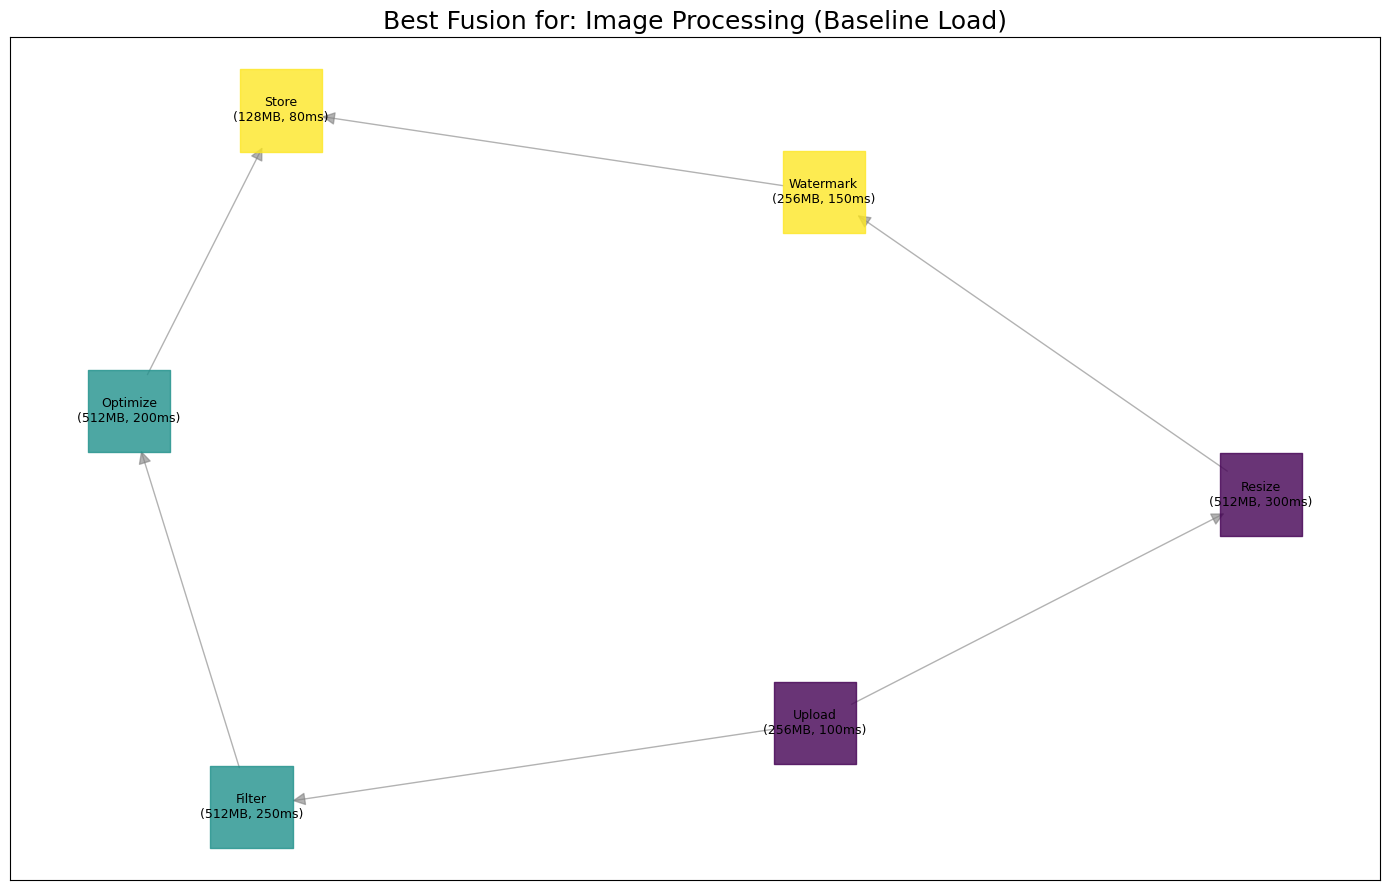

Saved fusion graph to: fusion_results/best_fusion_Image_Processing_(Baseline_Load).png

  TESTING APPLICATION: IMAGE PROCESSING (HIGH LOAD)
  CONSTRAINTS: Max Memory/Group = 1024MB, Max Latency = 700ms, Network Hop = 10ms
  LOAD PROFILE: resize=2.0x

Algorithm            Cost ($)     Latency (ms)    Groups   Runtime (ms)    Feasible   Notes
---------------------------------------------------------------------------------------------------------
Singleton            0.000049     930.0           1        0.06            ✗          
MinWCut Heuristic    0.000100     940.0           3        0.08            ✗          
NoFusion             0.000186     960.0           6        0.28            ✗          
Greedy TP (GrTP)     inf          930.0           0        0.02            ✗          
Costless (CSP)       inf          inf             0        8.19            ✗          Infeasible on critical path
MtxILP (Optimal)     inf          inf             0        22.27           ✗          Inf

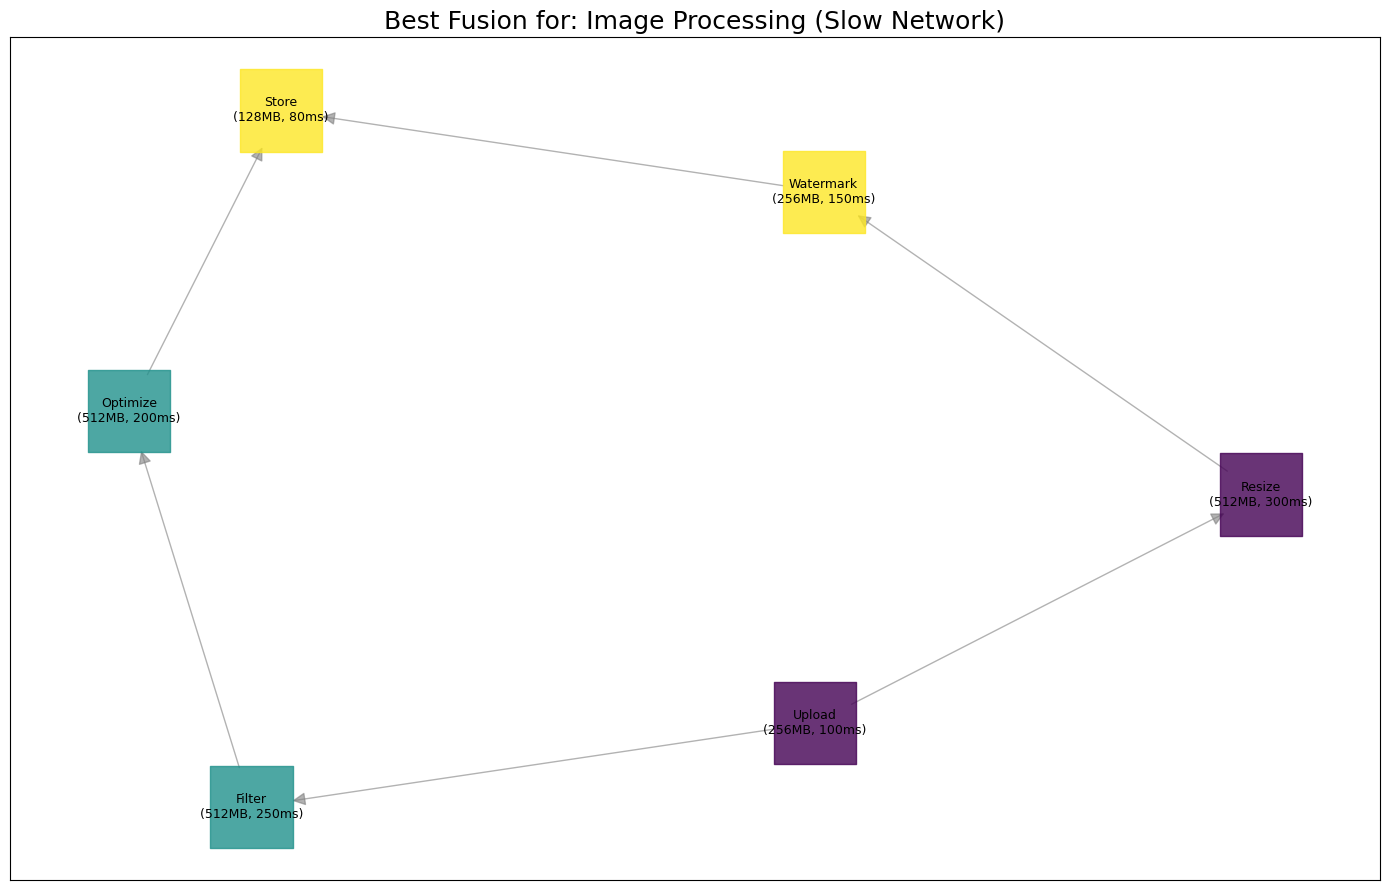

Saved fusion graph to: fusion_results/best_fusion_Image_Processing_(Slow_Network).png


In [15]:
class ApplicationBuilder:
    @staticmethod
    def create_from_spec(spec: Dict) -> Application:
        functions = {fid: LambdaFunction(id=fid, name=props['name'], memory=props['mem'], baseline_runtime=props['rt'], load_factor=spec.get('loads', {}).get(fid, 1.0)) for fid, props in spec['functions'].items()}
        for fid, props in spec['functions'].items():
            if 'children' in props:
                for child_id, data_bytes in props['children'].items():
                    functions[fid].add_child(functions[child_id], data_bytes)
        return Application(name=spec['name'], functions=list(functions.values()), critical_path_ids=spec['critical_path'], max_memory=spec['constraints']['max_memory'], max_latency=spec['constraints']['max_latency'], network_hop_delay=spec['constraints'].get('network_delay', 10))

class FusionTester:
    def __init__(self, output_dir="fusion_results"):
        self.output_dir = output_dir
        if not os.path.exists(self.output_dir): os.makedirs(self.output_dir)

    def run_test_on_app(self, app: Application):
        print(f"\n{'=' * 90}")
        print(f"  TESTING APPLICATION: {app.name.upper()}")
        print(f"  CONSTRAINTS: Max Memory/Group = {app.max_memory}MB, Max Latency = {app.max_latency}ms, Network Hop = {app.network_hop_delay}ms")
        print(f"  LOAD PROFILE: " + ", ".join([f"{f.id}={f.load_factor:.1f}x" for f in app.functions if f.load_factor > 1.0]) or "Baseline (1.0x)")
        print(f"{'=' * 90}")

        algorithms = [FusionAlgorithms.no_fusion, FusionAlgorithms.singleton, FusionAlgorithms.min_w_cut_heuristic, FusionAlgorithms.greedy_tree_partitioning, FusionAlgorithms.costless_csp, FusionAlgorithms.mtx_ilp]
        results = []
        for alg_func in algorithms:
            try: results.append(alg_func(app))
            except Exception as e:
                import traceback
                print(f"Error running {alg_func.__name__}: {e}")
                traceback.print_exc()

        print(f"\n{'Algorithm':<20} {'Cost ($)':<12} {'Latency (ms)':<15} {'Groups':<8} {'Runtime (ms)':<15} {'Feasible':<10} {'Notes'}")
        print("-" * 105)
        feasible_results = [r for r in results if r.get('feasible')]
        optimal_cost = min((r.get('cost', float('inf')) for r in feasible_results), default=float('inf'))
        results.sort(key=lambda x: (not x.get('feasible', False), x.get('cost', float('inf'))))

        for res in results:
            feasible_mark = "✓" if res.get('feasible') else "✗"
            optimal_mark = "(Optimal)" if res.get('feasible') and abs(res.get('cost', float('inf')) - optimal_cost) < 1e-9 else ""
            runtime_str = f"{res.get('runtime', 0):.2f}" if 'runtime' in res and res.get('runtime', 0) > 0 else "N/A"
            note = res.get('error', optimal_mark)
            print(f"{res.get('name', 'Unknown'):<20} {res.get('cost', float('inf')):<12.6f} {res.get('latency', float('inf')):<15.1f} {len(res.get('groups', [])):<8} {runtime_str:<15} {feasible_mark:<10} {note}")

        if feasible_results:
            best_result = min(feasible_results, key=lambda x: x.get('cost', float('inf')))
            print(f"\nVisualizing best feasible solution from '{best_result.get('name', 'Unknown')}'...")
            filename = f"best_fusion_{app.name.replace(' ', '_')}.png"
            self.visualize_fusion(best_result.get('groups', []), f"Best Fusion for: {app.name}", filename)
        else:
            print("\nNo feasible solution found by any algorithm under the given constraints.")
        return results

    def visualize_fusion(self, groups_of_funcs: List[List[LambdaFunction]], title: str, filename: str):
        if not groups_of_funcs: return
        G = nx.DiGraph()
        all_funcs = [func for group in groups_of_funcs for func in group]

        composite_groups = [CompositeFunction(g) for g in groups_of_funcs]
        func_to_composite_map = FusionAlgorithms._get_func_to_group_map(composite_groups)

        colors = plt.cm.viridis(np.linspace(0, 1, len(composite_groups)))

        for func in all_funcs:
            label = f"{func.name.split()[0]}\n({func.memory}MB, {func.runtime}ms)"
            group_obj = func_to_composite_map.get(func.id)
            group_idx = composite_groups.index(group_obj) if group_obj else -1
            G.add_node(func.id, label=label, group_id=group_idx)
        for func in all_funcs:
            for child in func.children:
                if child.id in G: G.add_edge(func.id, child.id)

        plt.figure(figsize=(14, 9))
        pos = nx.spring_layout(G, seed=42, k=1.5, iterations=70)

        valid_nodes = [node for node in G.nodes() if 0 <= G.nodes[node]['group_id'] < len(colors)]
        valid_colors = [colors[G.nodes[node]['group_id']] for node in valid_nodes]

        nx.draw_networkx_nodes(G, pos, nodelist=valid_nodes, node_size=3500, node_color=valid_colors, node_shape='s', alpha=0.8)
        nx.draw_networkx_edges(G, pos, alpha=0.6, edge_color='gray', arrows=True, arrowsize=20, node_size=3500)
        labels = {node: G.nodes[node]['label'] for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, font_size=9, font_color='black')
        plt.title(title, fontsize=18); plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, filename));
        plt.show()
        print(f"Saved fusion graph to: {os.path.join(self.output_dir, filename)}")


def get_test_apps():
    """Defines the application specs for testing, including different load scenarios."""

    image_processing_baseline = {
        'name': 'Image Processing (Baseline Load)',
        'functions': {
            'upload': {'name': 'Upload', 'mem': 256, 'rt': 100, 'children': {'resize': 5242880, 'filter': 5242880}},
            'resize': {'name': 'Resize', 'mem': 512, 'rt': 300, 'children': {'watermark': 2097152}},
            'filter': {'name': 'Filter', 'mem': 512, 'rt': 250, 'children': {'optimize': 3145728}},
            'watermark': {'name': 'Watermark', 'mem': 256, 'rt': 150, 'children': {'store': 2097152}},
            'optimize': {'name': 'Optimize', 'mem': 512, 'rt': 200, 'children': {'store': 1048576}},
            'store': {'name': 'Store', 'mem': 128, 'rt': 80}
        },
        'critical_path': ['upload', 'resize', 'watermark', 'store'],
        'constraints': {'max_memory': 1024, 'max_latency': 700, 'network_delay': 10}
    }

    image_processing_high_load = {
        'name': 'Image Processing (High Load)',
        'functions': image_processing_baseline['functions'],
        'critical_path': image_processing_baseline['critical_path'],
        'constraints': image_processing_baseline['constraints'],
        'loads': {'resize': 2.0}
    }

    image_processing_slow_network = {
        'name': 'Image Processing (Slow Network)',
        'functions': image_processing_baseline['functions'],
        'critical_path': image_processing_baseline['critical_path'],
        'constraints': {'max_memory': 1024, 'max_latency': 800, 'network_delay': 50}, # Slower network, slightly relaxed latency
        'loads': {}
    }

    return [
        ApplicationBuilder.create_from_spec(image_processing_baseline),
        ApplicationBuilder.create_from_spec(image_processing_high_load),
        ApplicationBuilder.create_from_spec(image_processing_slow_network),
    ]

if __name__ == "__main__":
    tester = FusionTester()
    test_applications = get_test_apps()

    for app in test_applications:
        tester.run_test_on_app(app)